In [1]:
import numpy as np
import scipy as sp
import os
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve

sns.set(context='notebook', style='white', font_scale=1.2)

In [2]:
try:
    import crossmapy as cmp
except:
    import sys
    sys.path.append('../')
    import crossmapy as cmp

In [3]:
res_dir = f'results/brain/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [4]:
def main_all(name):
    wdir = '../data/brain'
    raw = np.load(f'{wdir}/SpikeBin_{name}.npy')

    raw_mean = np.mean(raw, axis=0).T
    DCMC = cmp.DirectCrossMappingCardinality(embed_dim=8)
    DCMC.fit(raw_mean)
    
    res_dir = f'results/brain/'
    np.save(f'{red_dir}/{name}_DCMC.npy', DCMC.scores)
    print(name, 'finish')
    
def main_ind(name, i):
    wdir = '../data/brain'
    endp = np.load(f'{wdir}/EndpointIndex.npy')
    raw = np.load(f'{wdir}/SpikeBin_{name}.npy')

    raw_mean = np.mean(raw[endp == i], axis=0).T
    DCMC = cme.DirectCrossMappingCardinality(embed_dim=8)
    DCMC.fit(raw_mean)
    
    res_dir = f'results/brain/'
    np.save(f'{red_dir}/{name}_DCMC_dir{i+1}.npy', DCMC.scores)
    print(name, i, 'finish')

In [ ]:
periods = ['TC', 'GO', 'MO']
for p in periods:
    main_all(p)
    for i in range(8):
        main_ind(p, i)

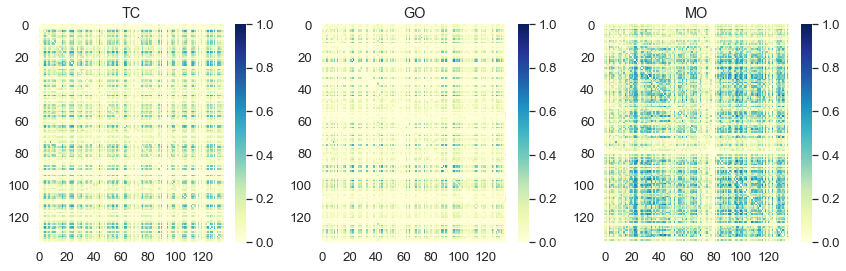

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, name in enumerate(['TC', 'GO', 'MO']):
    mat = np.load(f'{res_dir}/{name}_DCMC.npy')
    ax[i] = cmp.plot_score_matrix(mat, annot=False, tick_bin=20, linewidths=0, vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(name)

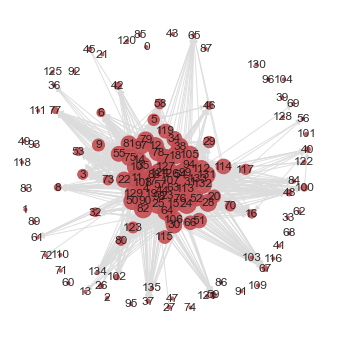

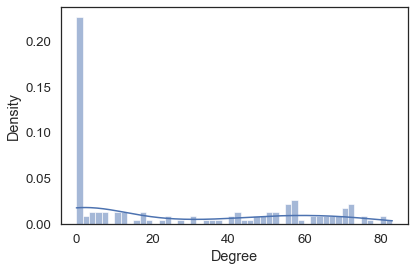

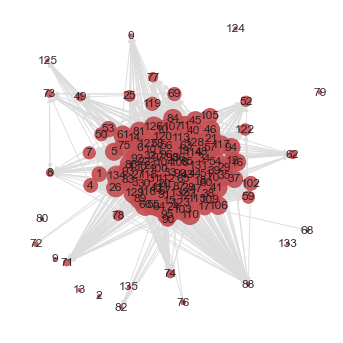

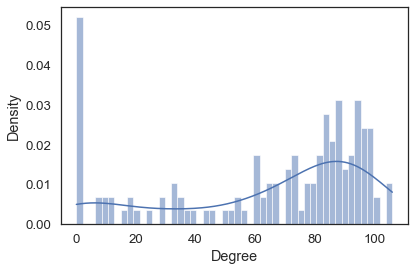

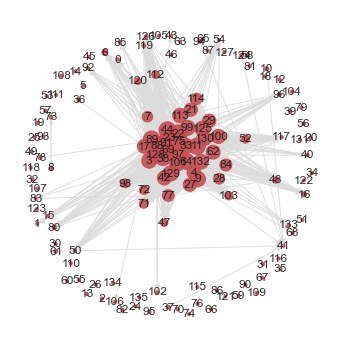

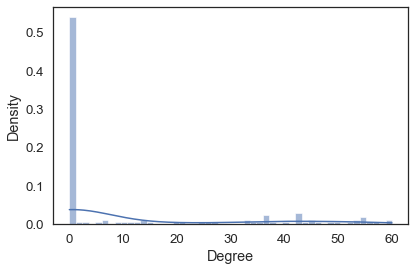

In [32]:
cutoff = .2
for name in ['TC', 'MO', 'GO']:
    scores = np.load(f'{res_dir}/{name}_DCMC.npy')

    adj_mat = cmp.discretize_score(scores, cutoff) #to_adj_mat(scores, cutoff)
    np.fill_diagonal(adj_mat, 0.)
    G = nx.from_numpy_array(adj_mat, create_using=nx.DiGraph)
    pos = nx.spring_layout(G, k=1, seed=1)

    fig, ax = plt.subplots(figsize=(5, 5))
    node_color = ['r'] * 136 #['b']*36 + ['r']*100
    node_size = [5*d[1] + 10 for d in G.out_degree]
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=True,
        node_color=node_color,
        node_size=node_size,
        edge_color="gainsboro",
        alpha=0.9,
    )
    ax.margins(0.05, 0.05)
    fig.tight_layout()
    plt.axis("off")

    od_seq = [d[1] for d in G.out_degree]
    fig, ax = plt.subplots()
    sns.histplot(od_seq, kde=True, bins=50, stat="density", ax=ax)
    ax.set_xlabel('Degree')
    plt.tight_layout()

In [9]:
score_mats = []
for name in ['TC', 'GO', 'MO']:
    score_list = []
    for d in range(1, 9):
        scores = np.load(f'{res_dir}/{name}_DCMC_dir{d}.npy')
        score_list.append(cmp.skip_diag_tri(scores).ravel())
    score_mat = np.asarray(score_list)
    score_mats.append(score_mat)

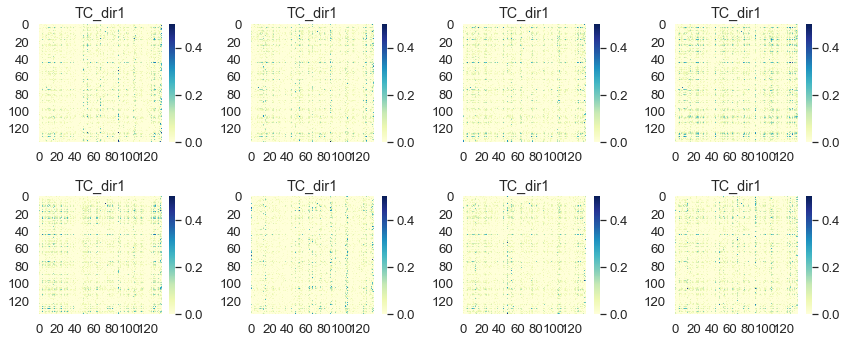

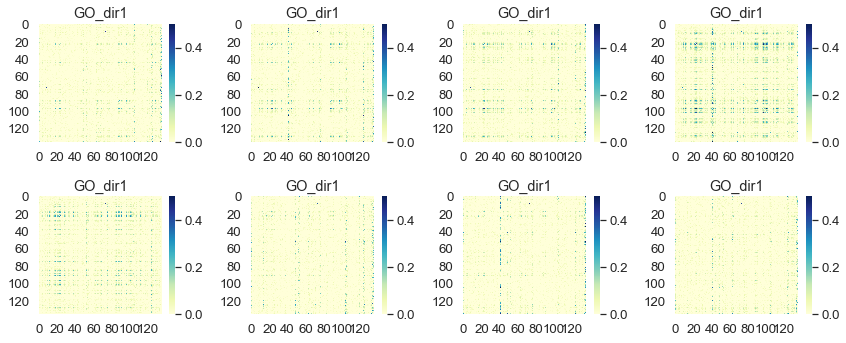

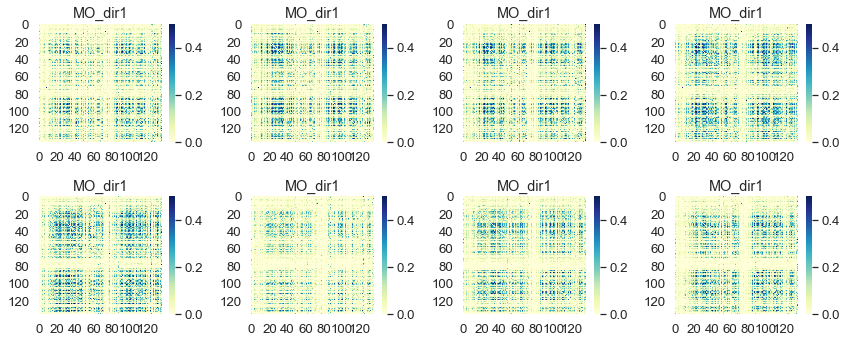

In [16]:
for j, name in enumerate(['TC', 'GO', 'MO']):
    fig, ax = plt.subplots(2, 4, figsize=(12, 5))
    ax = ax.flatten()
    for i in range(8):
        ax[i] = cmp.plot_score_matrix(cmp.score_seq_to_matrix(score_mats[j][i]), annot=False, tick_bin=20, linewidths=0, vmin=0, vmax=0.5, ax=ax[i])
        ax[i].set_title(f'{name}_dir{1}')

In [11]:
score_mats[0].shape

(8, 18360)

In [30]:
import matplotlib as mpl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

rainbow_t = (truncate_colormap(plt.get_cmap("rainbow"), minval=0.2))

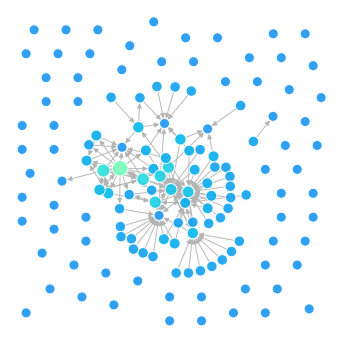

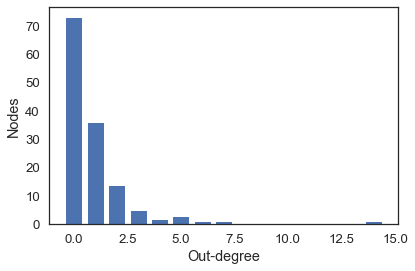

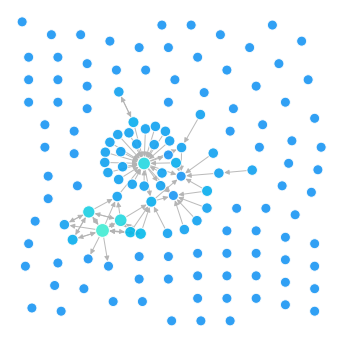

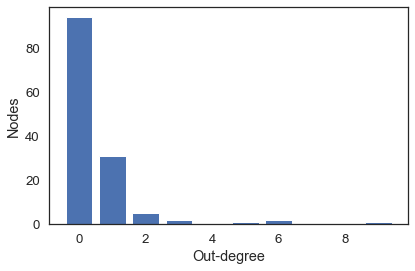

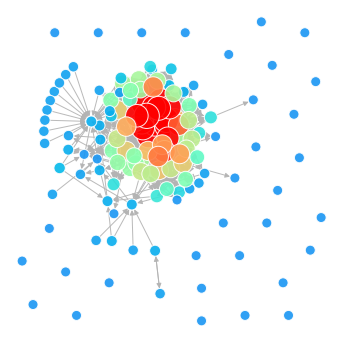

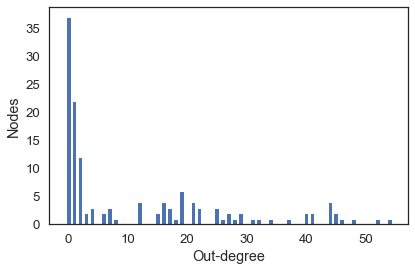

In [31]:
cutoff = 0.2
mean_list = []
std_list = []
for name in ['TC', 'GO', 'MO']:
    scores = np.load(f'{res_dir}/{name}_DCMC_dir1.npy')

    scores[scores > cutoff] = 1
    scores[scores < cutoff] = 0
    G = nx.from_numpy_array(scores, create_using=nx.DiGraph)
    pos = nx.nx_agraph.graphviz_layout(G)
    od_seq = [d[1] for d in G.out_degree]
    node_size = [10 * d[1] + 100 for d in G.out_degree]

    fig, ax = plt.subplots(figsize=(5, 5))
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=od_seq, alpha=.9, cmap=rainbow_t,
                     edgecolors='w', vmin=0, vmax=40, edge_color='0.7', with_labels=False)
    ax.margins(0.05, 0.05)
    ax.set_axis_off()
    fig.tight_layout()

    degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
    fig, ax = plt.subplots()
    ax.bar(*np.unique(degree_sequence, return_counts=True))
    ax.set_xlabel('Out-degree')
    ax.set_ylabel('Nodes')
    plt.tight_layout()

In [27]:
def cycle_idx_distance(i, j, n=8):
    a = abs(i - j)
    b = n - a
    return min(a, b)

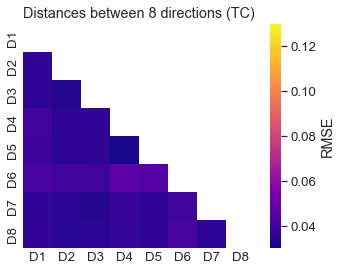

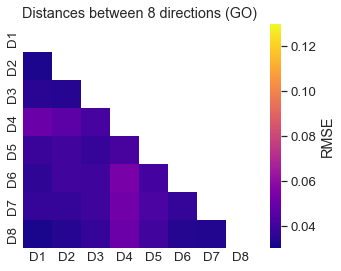

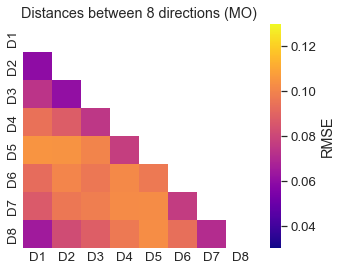

In [28]:
mean_list = []
std_list = []
for name in ['TC', 'GO', 'MO']:
    rmse = np.zeros((8, 8))
    scores_list = [np.load(f'{res_dir}/{name}_DCMC_dir{d}.npy') for d in range(1, 9)]
    init_dict = {i: [] for i in range(1, 5)}
    for i in range(8):
        for j in range(i+1, 8):
            scores1 = cmp.skip_diag_tri(scores_list[i]).ravel()
            scores2 = cmp.skip_diag_tri(scores_list[j]).ravel()
            rmse[i, j] = np.sqrt(np.mean((scores1 - scores2) ** 2))
            tmp_dis = cycle_idx_distance(i, j, 8)
            # print(i, j, tmp_dis)
            init_dict[tmp_dis].append(rmse[i, j])
    # rmse = rmse + rmse.T
    rmse[rmse == 0] = np.nan

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(rmse.T, cmap='plasma', cbar_kws={'label': 'RMSE'}, vmin=0.03, vmax=0.13)
    tlabels = [f'D{i}' for i in range(1, 9)]
    ax.set_xticklabels(tlabels, va='center', ha='center')
    ax.set_yticklabels(tlabels, va='center', ha='center')
    ax.set_title(f'Distances between 8 directions ({name})')
    plt.tight_layout()

    means = [np.mean(init_dict[i]) for i in range(1, 5)]
    stds = [np.std(init_dict[i]) for i in range(1, 5)]
    mean_list.append(means)
    std_list.append(stds)

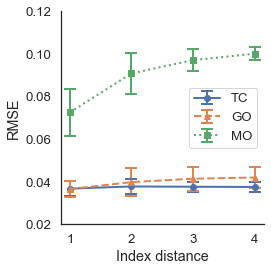

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
ls_list = ['-', '--', ':']
markers = ['o', '^', 's']
for i, v in enumerate(['TC', 'GO', 'MO']):
    ax.errorbar(range(1, 5), mean_list[i], yerr=std_list[i], ls=ls_list[i],
                marker=markers[i], linewidth=2, capsize=6, label=v, capthick=2)
sns.despine()
ax.set_xticks(range(1, 5))
ax.set_ylim(0.02, 0.12)
# ax.grid(axis='y')
#ax.legend(loc='upper left', ncol=1)
ax.legend()
ax.set_xlabel('Index distance')
ax.set_ylabel('RMSE')
plt.tight_layout()

In [17]:
pca = PCA(n_components=3)
pca.fit(np.vstack(score_mats))
pca.explained_variance_ratio_

array([0.52795157, 0.09749447, 0.08589067])

In [19]:
clist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#9467bd', '#d62728', '#e377c2', '#bcbd22', '#17becf']

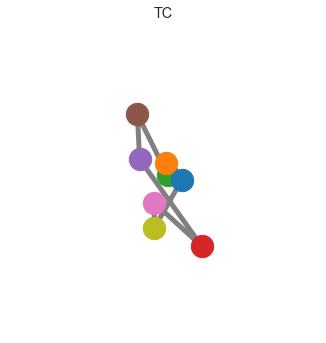

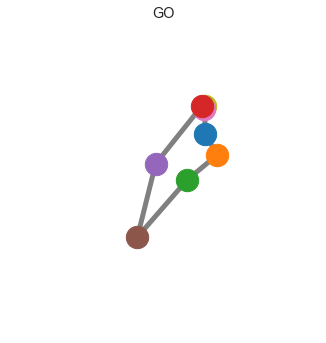

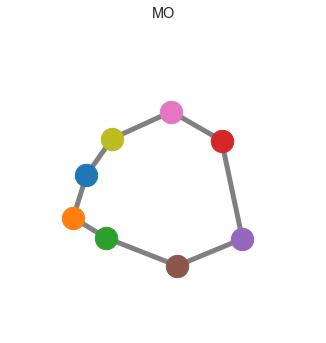

In [21]:
for n, name in enumerate(['TC', 'GO', 'MO']):
    X_r = pca.transform(score_mats[n])
    X_r2 = np.vstack((X_r, X_r[:1]))

    if name == 'TC':
        row, col = 180, 60
    elif name == 'GO':
        row, col = 0, 120
    else:
        row, col = 15, 10

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.view_init(row, col)

    for i in range(8):
        ax.scatter3D(X_r[i, 0], X_r[i, 1], X_r[i, 2], c=clist[i], label=f'D{i+1}', s=500, zorder=2)
    ax.plot3D(X_r2[:, 0], X_r2[:, 1], X_r2[:, 2], c='gray', zorder=1, lw=5)
    # ax.set_xlim(-lim, lim)
    # ax.set_ylim(-lim, lim)
    # ax.set_zlim(-lim, lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # ax.set_xlabel('PC1')
    # ax.set_ylabel('PC2')
    # ax.set_zlabel('PC3')
    ax.set_axis_off()
    # ax.legend(bbox_to_anchor=[1.1,0,0.2,0.8])
    ax.set_title(f'{name}')
    fig.tight_layout()

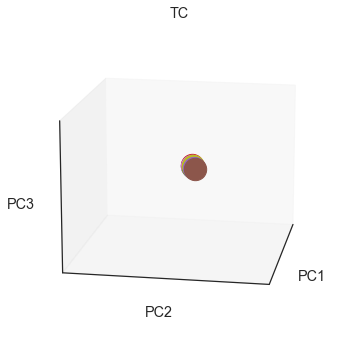

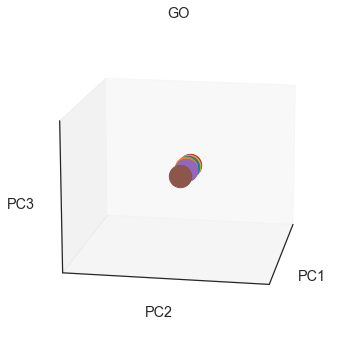

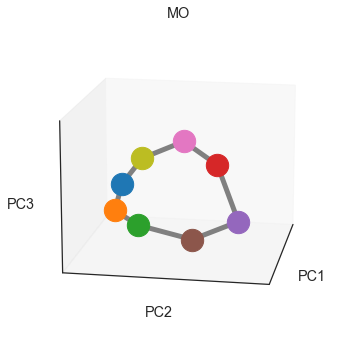

In [24]:
for n, name in enumerate(['TC', 'GO', 'MO']):
    X_r = pca.transform(score_mats[n])
    X_r2 = np.vstack((X_r, X_r[:1]))
    row, col = 15, 10

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.view_init(row, col)

    for i in range(8):
        ax.scatter3D(X_r[i, 0], X_r[i, 1], X_r[i, 2], c=clist[i], label=f'D{i+1}', s=500, zorder=2)
    ax.plot3D(X_r2[:, 0], X_r2[:, 1], X_r2[:, 2], c='gray', zorder=1, lw=5)
    
    lim = 10
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'{name}')
    fig.tight_layout()

In [33]:
def main_sim(run_idx, method, embed_dim):
    wdir = r'results/brain/'
    res_file = f'{wdir}/run{run_idx}_{method}_e{embed_dim}.npy'

    if not os.path.exists(res_file):
        sim_path = r'../data/brain/sim_run{}/toy_data_32.npy'.format(run_idx)
        rdata = np.load(sim_path)

        np.random.seed(0)
        rdata_n = rdata + np.random.normal(0, 0.001, rdata.shape)

        if method == 'CCM':
            model = cmp.ConvergeCrossMapping(embed_dim=embed_dim)
        elif method == 'PCM':
            model = cmp.PartialCrossMapping(embed_dim=embed_dim)
        elif method == 'CMC':
            model = cmp.CrossMappingCardinality(embed_dim=embed_dim)
        elif method == 'DCMC':
            model = cmp.DirectCrossMappingCardinality(embed_dim=embed_dim)

        scores = np.empty((100, 32, 32))
        for j in tqdm(range(100)):
            raw_mean = rdata_n[j].T
            model.fit(raw_mean)
            scores[j] = model.scores
        np.save(res_file, scores)

In [ ]:
for run_idx in range(1, 6):
    for method in ['CCM', 'PCM', 'CMC', 'DCMC']:
        for embed_dim in range(3, 11):
            main_sim(run_idx, method, embed_dim)

In [35]:
methods = ['CCM', 'PCM', 'DCMC']
avg_res = []
run = 1
embed_dim = 10

edges = np.load(f'{res_dir}/run{run}_truth.npy').astype('int')
truth_score = cmp.skip_diag_tri(edges).ravel()

avg_fprs = []
avg_tprs = []
for m in methods:
    score_mat = np.load(f'{res_dir}/run{run}_{m}_e{embed_dim}.npy')
    avg_score = score_mat.mean(0)

    avg_fpr, avg_tpr, _ = roc_curve(truth_score, cmp.skip_diag_tri(avg_score).ravel())
    avg_fprs.append(avg_fpr)
    avg_tprs.append(avg_tpr)

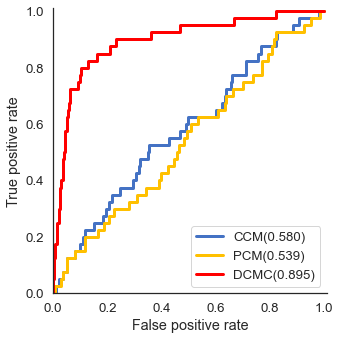

In [37]:
fig, ax = cmp.plot_mul_roc_curve(avg_fprs, avg_tprs, labels=methods, colors=['#4472C4', '#FFC000', '#FF0000'],
                                 xlabel='False positive rate', ylabel='True positive rate', lw=3, diag_line=False)
sns.despine(ax=ax)
ax.set_xlim(0, 1.01)
ax.set_ylim(0, 1.01)
ax.grid()

In [ ]:
methods = ['CCM', 'PCM', 'CMC', 'DCMC']
avg_res = []
for run in range(5):
    edges = np.load(f'{res_dir}/run{run}_truth.npy').astype('int')
    truth_score = cmp.skip_diag_tri(edges).ravel()
    for embed_dim in range(3, 11):
        aucs_list = []
        avg_aucs = []
        for m in methods:
            score_mat = np.load(f'{res_dir}/run{run}_{m}_e{embed_dim}.npy')
            avg_score = score_mat.mean(0)
            avg_auc = metrics.roc_auc_score(truth_score, cme.skip_diag_tri(avg_score).ravel())
            avg_aucs.append(avg_auc)
            avg_res.append([noise, run, embed_dim, m, avg_auc])

df_avg_auc = pd.DataFrame(avg_res, columns=['Noise', 'Run', 'Embed', 'Method', 'AUC'])
df_avg_auc.to_csv(f'{res_dir}/avg_auc_df.csv', index=False)

In [38]:
df_avg_auc = pd.read_csv(f'{res_dir}/avg_auc_df.csv')

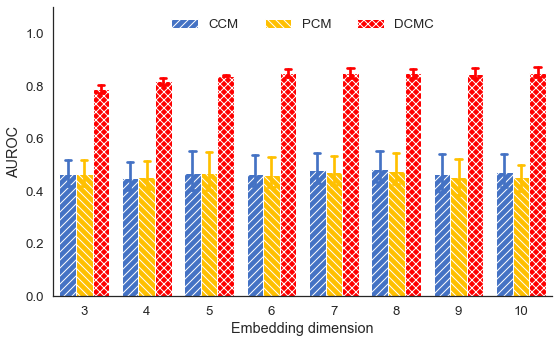

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(x='Embed', y='AUC', hue='Method', data=df_avg_auc[df_avg_auc.Method != 'CMC'], ax=ax,
                 palette=['#4472C4', '#FFC000', '#FF0000'], capsize=.1, saturation=1)

hatches = ['///', "\\\\\\", 'xxx']
for i, p in enumerate(ax.patches):
    idx = i // 8
    p.set_hatch(hatches[idx])
for j, l in enumerate(ax.lines):
    idx = j // 24
    l.set_color(['#4472C4', '#FFC000', '#FF0000'][idx])

ax.legend(ncol=4, loc='upper center', frameon=False)
ax.get_legend().set_title('')
ax.set_ylim(0, 1.1)
ax.set_xlabel('Embedding dimension')
ax.set_ylabel('AUROC')
sns.despine(ax=ax)

plt.tight_layout()

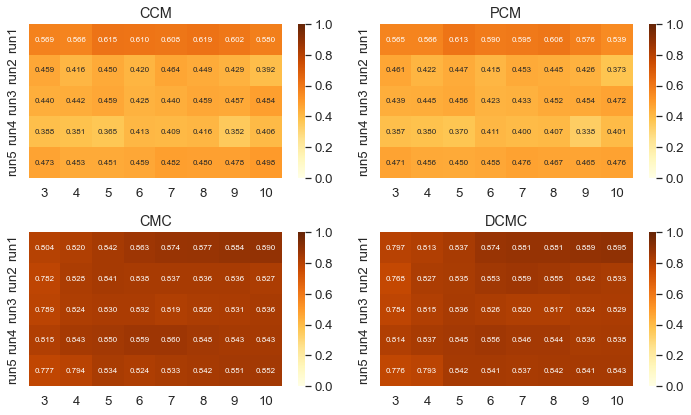

In [42]:
methods = ['CCM', 'PCM', 'CMC', 'DCMC']

fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, m in enumerate(methods):
    auc_mat = df_avg_auc[df_avg_auc.Method == m].AUC.to_numpy().reshape(5, 8)
    sns.heatmap(auc_mat, vmin=0.0, vmax=1.0, cmap="YlOrBr", ax=ax[i], annot=True, fmt='.3f', annot_kws={'fontsize': 8})
    ax[i].set_xticklabels(range(3, 11))
    ax[i].set_yticklabels([f'run{j+1}' for j in range(5)], va='center')
    ax[i].set_title(m)
plt.tight_layout()